#Sentiment and Network Analysis to determine Product (iPhone 13) Success

##1. Installing required packages

####1.1. Installing python 3.8 for snsscrape library

In [ ]:
!pip install -U textblob

In [ ]:
!sudo apt install python3.8
!sudo apt install python3.8-distutils

!wget https://bootstrap.pypa.io/get-pip.py
!sudo python3.8 get-pip.py

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3.8 is already the newest version (3.8.12-1+bionic1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'python3-distutils' instead of 'python3.8-distutils'
python3-distutils is already the newest version (3.6.9-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
--2021-10-31 16:55:02--  https://bootstrap.pypa.io/get-pip.py
Resolving bootstrap.pypa.io (bootstrap.pypa.io)... 151.101.0.175, 151.101.64.175, 151.101.128.175, ...
Connecting to bootstrap.pypa.io (bootstra

In [ ]:
! pip3 install git+https://github.com/JustAnotherArchivist/snscrape.git

  Cloning https://github.com/JustAnotherArchivist/snscrape.git to /tmp/pip-req-build-95pqa6py
  Running command git clone --filter=blob:none -q https://github.com/JustAnotherArchivist/snscrape.git /tmp/pip-req-build-95pqa6py
  Resolved https://github.com/JustAnotherArchivist/snscrape.git to commit a6b6f3faaa26f541d9469651451340096b5abc92
  Preparing metadata (setup.py) ... done


####1.2. Importing required libraries

In [ ]:
import pandas as pd
import warnings
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
from collections.abc import Iterable
from textblob import TextBlob
import re
from wordcloud import WordCloud
import networkx as nx 
import numpy as np
from operator import itemgetter

##2. Data Collection

####Scraping tweets of 30 days each having 200 tweets per day

In [ ]:
# defining dates from the release of iphone 13 from September 24th,2021 till October 23,2021
start_date = datetime.date(2021, 9 , 24)
number_of_days = 31

date_list = [(start_date + datetime.timedelta(days = day)).isoformat() for day in range(number_of_days)]

In [ ]:
# using snscrape to scrape tweets for required dates based on the search of 'iphone 13'
# pleaase wait for 3-4 min
for i in range(len(date_list)-1):
  os.system("snscrape --jsonl --max-results 200 twitter-search '{} since:{} until:{}' > file{}.json".format('iphone 13',date_list[i],date_list[i+1],i))

# collected data is stored in json files

In [ ]:
# merging all the 30-days tweet data in one file
data = pd.DataFrame()

for i in range(len(date_list)-1):
  df= pd.read_json('file{}.json'.format(i),lines=True)
  data=pd.concat([data,df])

#total data collected
data.shape

(6000, 28)

##3. Data Preprocessing

#### Looking at the data

In [ ]:
# looking at the data
data.head()

,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,outlinks,tcooutlinks,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags
0,snscrape.modules.twitter.Tweet,https://twitter.com/miro_august/status/1441553...,2021-09-24 23:59:53+00:00,@stefany_sds Te mandaria msg do meu iphone 13,@stefany_sds Te mandaria msg do meu iphone 13,1441553001634750465,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,2,0,1441514761435353095,pt,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,None,None,None,NaN,None,1.441515e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",None,None,None,None
1,snscrape.modules.twitter.Tweet,https://twitter.com/BubbaPudding/status/144155...,2021-09-24 23:59:52+00:00,iPhone 13 Pro had me sold since the announceme...,iPhone 13 Pro had me sold since the announceme...,1441552997478195202,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,5,0,1441552997478195202,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,None,None,None,NaN,None,NaN,None,None,None,None,None,None
2,snscrape.modules.twitter.Tweet,https://twitter.com/Tiaguins13/status/14415529...,2021-09-24 23:59:46+00:00,"Vou ver o unboxing do novo iPhone 13 pro max, ...","Vou ver o unboxing do novo iPhone 13 pro max, ...",1441552973058826243,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,1,0,0,1441552973058826243,pt,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,None,None,None,NaN,None,NaN,None,None,None,None,None,None
3,snscrape.modules.twitter.Tweet,https://twitter.com/allen_0927/status/14415529...,2021-09-24 23:59:45+00:00,@sekaigaowaru99 iPhone帰る予定なんですけど13の使い心地はどうですか？,@sekaigaowaru99 iPhone帰る予定なんですけど13の使い心地はどうですか？,1441552971687284749,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,0,0,1441406099710570506,ja,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,None,None,None,NaN,None,1.441406e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",None,None,None,None
4,snscrape.modules.twitter.Tweet,https://twitter.com/RickWNDRS/status/144155295...,2021-09-24 23:59:42+00:00,iPhone 13 Pro is a W. Go get one 🤟,iPhone 13 Pro is a W. Go get one 🤟,1441552957359620100,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,0,0,1441552957359620100,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,None,None,None,NaN,None,NaN,None,None,None,None,None,None


In [ ]:
data.info #columns having complelety null are removed later

<bound method DataFrame.info of                               _type  ... cashtags
0    snscrape.modules.twitter.Tweet  ...     None
1    snscrape.modules.twitter.Tweet  ...     None
2    snscrape.modules.twitter.Tweet  ...     None
3    snscrape.modules.twitter.Tweet  ...     None
4    snscrape.modules.twitter.Tweet  ...     None
..                              ...  ...      ...
195  snscrape.modules.twitter.Tweet  ...     None
196  snscrape.modules.twitter.Tweet  ...     None
197  snscrape.modules.twitter.Tweet  ...     None
198  snscrape.modules.twitter.Tweet  ...     None
199  snscrape.modules.twitter.Tweet  ...     None

[6000 rows x 28 columns]>

####Chaniging the date format

In [ ]:
data['date']=  pd.to_datetime(data['date'], format='%Y:%M:%D').dt.date

####Filtering English tweets

In [ ]:
# only english tweets are fetched
data=data[data['lang']=='en']

#sorting the data based on dates
data=data.sort_values('date')

#looking at the shape of the data
print(data.shape)
data.reset_index(inplace=True)
data.head(3)

(2981, 28)


,index,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,outlinks,tcooutlinks,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags
0,1,snscrape.modules.twitter.Tweet,https://twitter.com/BubbaPudding/status/144155...,2021-09-24,iPhone 13 Pro had me sold since the announceme...,iPhone 13 Pro had me sold since the announceme...,1441552997478195202,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,5,0,1441552997478195202,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,None,None,None,NaN,None,NaN,None,None,None,None,None,None
1,149,snscrape.modules.twitter.Tweet,https://twitter.com/jpeMEDIA/status/1441550281...,2021-09-24,iPhone 13 Pro's 120Hz display limits some thir...,iPhone 13 Pro's 120Hz display limits some thir...,1441550281909571587,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,0,1441550281909571587,en,"<a href=""https://dlvrit.com/"" rel=""nofollow"">d...",https://dlvrit.com/,dlvr.it,[https://j.mp/3AMRydS],[https://t.co/GuZmIx3L1L],"[{'_type': 'snscrape.modules.twitter.Photo', '...",NaN,None,NaN,None,None,None,None,None,None
2,146,snscrape.modules.twitter.Tweet,https://twitter.com/_wendyforbes_/status/14415...,2021-09-24,It’s time for a new iPhone 13! https://t.co/VB...,It’s time for a new iPhone 13! go.att.com/best...,1441550314738380803,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,1,0,1441550314738380803,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,"[http://go.att.com/bestiphonedeals, https://tw...","[https://t.co/VBxyZNgXKQ, https://t.co/EL1Mip3...",None,NaN,"{'_type': 'snscrape.modules.twitter.Tweet', 'u...",NaN,None,"[{'_type': 'snscrape.modules.twitter.User', 'u...",None,None,"[attexplore, sweepstakes]",None


#### Exploring User column to fetch user attributes

In [ ]:
# the user column in data in in the form of dictionaries.
#new dataframe is created to fetch the required attributes in the user dictionary
user_data = pd.DataFrame(columns=['userid','username','favouritesCount','followersCount','friendsCount','location','verified'])

for i in range(len(data)):
  user_data.loc[len(user_data.index)] = list([data['user'][i]['id'],data['user'][i]['username'],data['user'][i]['favouritesCount'],data['user'][i]['followersCount'],data['user'][i]['friendsCount'],data['user'][i]['location'],data['user'][i]['verified']])

#### Exploring Place and inReplyToUsername columns to fetch required attributes

In [ ]:
warnings.filterwarnings('ignore')
#country attribute is fetched from place
idx = data.place[data['place'].notnull()].index
for i in idx:
  data['place'][i]= data['place'][i]['country']

#username and userid of the tweet authors are fetched
data['inReplyToUsername']=None
data['inReplyToUserid']=None
idx = data.inReplyToUser[data['inReplyToUser'].notnull()].index
for i in idx:
  data['inReplyToUsername'][i]= data['inReplyToUser'][i]['username']
  data['inReplyToUserid'][i]= data['inReplyToUser'][i]['id']

#### Exploring mentionedUsers columns to get required attributes

In [ ]:
# fetching username and userid of the users mentioned in the tweet
users = []
users_id = []

for index,row in data.iterrows():
  if isinstance(row['mentionedUsers'],list):
    inUsers = []
    inIDs = []
    for y in row['mentionedUsers']:
      inUsers.append(y['username'])
      inIDs.append(int(y['id']))
    users.append(inUsers)
    users_id.append(inIDs)
  else:
    users.append([])
    users_id.append([])

data['mentionedUsers'] = users
data['user_mentions_id'] = users_id

#### Merging all the collected data into single dataframe

In [ ]:
data= data[['date','content','id','replyCount','retweetCount','likeCount','place','hashtags','inReplyToTweetId','inReplyToUsername','inReplyToUserid','mentionedUsers','user_mentions_id']]
total_data= pd.concat([data,user_data],axis=1)

In [ ]:
total_data.head()

,date,content,id,replyCount,retweetCount,likeCount,place,hashtags,inReplyToTweetId,inReplyToUsername,inReplyToUserid,mentionedUsers,user_mentions_id,userid,username,favouritesCount,followersCount,friendsCount,location,verified
0,2021-09-24,iPhone 13 Pro had me sold since the announceme...,1441552997478195202,0,0,5,None,None,NaN,None,None,[],[],95088198,BubbaPudding,19459,462,806,"Iowa, USA",False
1,2021-09-24,iPhone 13 Pro's 120Hz display limits some thir...,1441550281909571587,0,0,0,None,None,NaN,None,None,[],[],163126776,jpeMEDIA,911,3808,1592,United Kingdom,False
2,2021-09-24,It’s time for a new iPhone 13! https://t.co/VB...,1441550314738380803,0,0,1,None,"[attexplore, sweepstakes]",NaN,None,None,[cgthorn80],[558233346],138550562,_wendyforbes_,254,395,1266,United States,False
3,2021-09-24,@boostmobile When will the blue iPhone 13 Pro ...,1441550318127489025,1,0,0,None,None,1.441516e+18,boostmobile,9655952,[boostmobile],[9655952],2395491410,SacramentoJuare,51161,57,103,"Chicago, IL",False
4,2021-09-24,@zollotech Just got my iPhone 13 Pro. Huge upg...,1441550344748556296,0,0,0,None,None,1.441375e+18,zollotech,14863310,[zollotech],[14863310],910987480727506946,FightinHoey,8987,23,213,Alcatraz,False


##4. Sentimental Analysis

In [ ]:
sentiment=pd.DataFrame(columns=['Tweet','Polarity','Subjectivity','Overall'])

for i in total_data['content']:
  l2=[]
  #cleaning the tweets
  i=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", i).split())

  #textblob for calculating tweet's polarity and subjectivity
  blob=TextBlob(i)
  l2.append(i)
  l2.append(blob.sentiment.polarity)
  l2.append(blob.sentiment.subjectivity)

  if blob.sentiment.polarity>=0.05:
    l2.append("Positive")
  elif blob.sentiment.polarity<=-0.05:
    l2.append("Negative")
  else:
    l2.append("Neutral")
  sentiment.loc[len(sentiment.index)] = l2

In [ ]:
# Fetching postive and negative words from tweets
positive = [pos for pos in sentiment.Tweet[sentiment['Overall']=='Positive']]
negative = [pos for pos in sentiment.Tweet[sentiment['Overall']=='Negative']]
positive=' '.join(positive)
negative=' '.join(negative)

#product's name is excluded to get insights on product features
stopwords=['iphone','13','pro','max','phone','apple']

#merging the tokens
pos= [words for words in positive.split(' ') if words.lower() not in stopwords]
pos=' '.join(pos)
neg= [words for words in negative.split(' ') if words.lower() not in stopwords]
neg=' '.join(neg)

#### WordCloud of Positive words

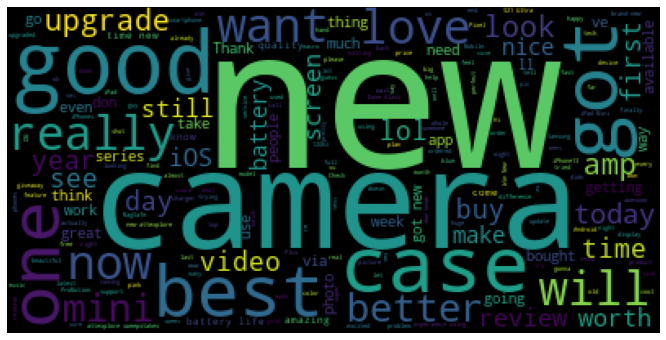

In [ ]:
wordcloud = WordCloud().generate(pos)
plt.figure(figsize=(18,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

users had a positive reaction towards features like camera, the look of the product, iOS, phone case, and more.

#### WordCloud of negative words

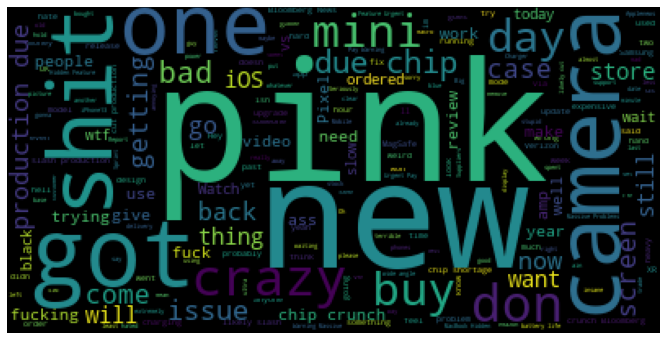

In [ ]:
wordcloud = WordCloud().generate(neg)
plt.figure(figsize=(18,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

users had a negative reaction like bad screen, issues with chip performance, pink case and more.


#### Visualizing tweets sentiments 

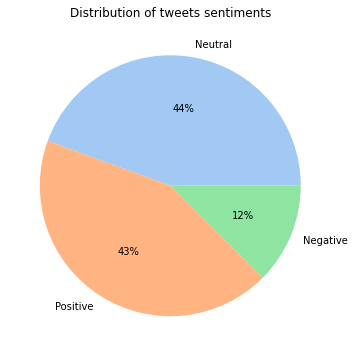

In [ ]:
#defining data
chart= pd.DataFrame(sentiment['Overall'].value_counts())
data = list(chart['Overall'])
labels = list(chart.index)

#defining Seaborn color palette to use
colors = sns.color_palette('pastel')

#creating pie chart
plt.figure(figsize=(6,6))
plt.title('Distribution of tweets sentiments')
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

#### Adding the setiments of each tweet to the main data

In [ ]:
total_data['sentiment']=sentiment['Overall']

#### Visualizing the distribution of Sentiments of tweets over 30 days

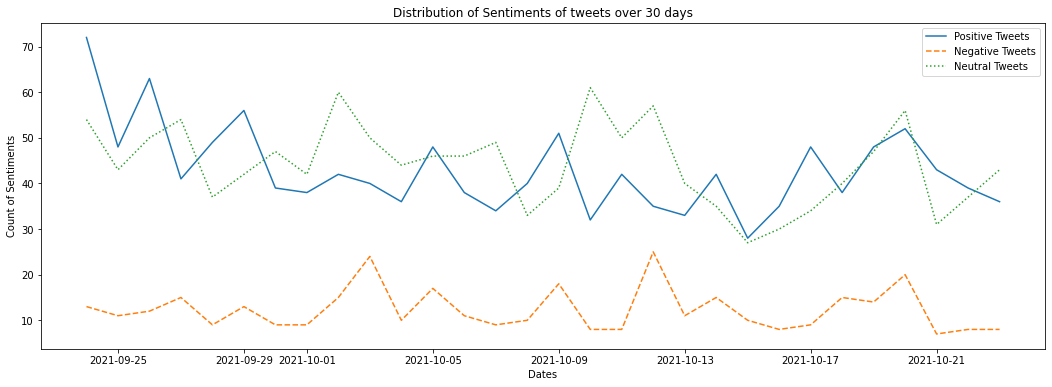

In [ ]:
#defining data
pos_data  = total_data[total_data['sentiment']=='Positive']
pos_counts = [len(pos_data[pos_data['date']==i]) for i in list(pos_data['date'].unique())]
neg_data  = total_data[total_data['sentiment']=='Negative']
neg_counts = [len(neg_data[neg_data['date']==i]) for i in list(neg_data['date'].unique())]
neu_data  = total_data[total_data['sentiment']=='Neutral']
neu_counts = [len(neu_data[neu_data['date']==i]) for i in list(neu_data['date'].unique())]

#plotting data
plt.figure(figsize=(18,6))
line_chart1 = plt.plot(list(pos_data['date'].unique()), pos_counts)
line_chart2 = plt.plot(list(neg_data['date'].unique()), neg_counts,'--')
line_chart3 = plt.plot(list(neu_data['date'].unique()), neu_counts,':')
plt.title('Distribution of Sentiments of tweets over 30 days')
plt.xlabel('Dates')
plt.ylabel('Count of Sentiments')

plt.legend(['Positive Tweets', 'Negative Tweets','Neutral Tweets'], loc=1)
plt.savefig('tweet-days.png')
plt.show()

Looking at the distribution of sentiments from the tweets over a period of 30 days, we can already notice the difference between the positive and negative tweets. In addition to this, we can observe that there is clear conflict when we try to analyse the behaviour of positive and neutral tweets. This indicates that there wasn’t a huge success rate of the product, in some way, the product did not perform to community’s expectation and thus the close difference in opinions.


#### Visualizing Top 20 popular hashtags

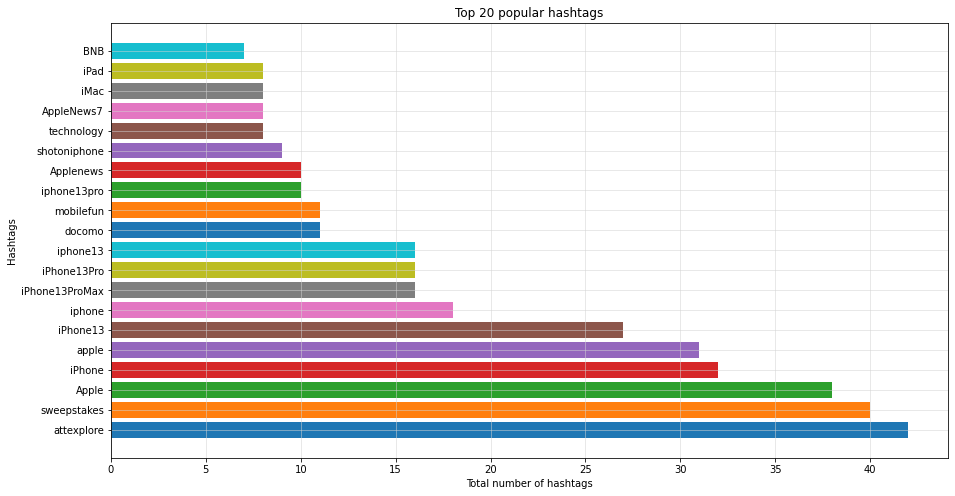

In [ ]:
#defining data
hashtags= list(total_data.hashtags[total_data['hashtags'].notnull()])
new_hash=[]
for i in hashtags:
  for j in i:
    new_hash.append(j)
new_hash = pd.Series(new_hash)

#plotting data
plt.figure(figsize=(15,8))
plt.grid(True, linewidth=0.5, color='#D3D3D3', linestyle='-')
plt.barh(list(new_hash.value_counts().index)[:20], list(new_hash.value_counts())[:20], color =sns.color_palette())
plt.title('Top 20 popular hashtags')
plt.xlabel('Total number of hashtags')
plt.ylabel('Hashtags')
plt.savefig('hash.png')
plt.show()

## 5. Network Analysis

#### Function to calculate the interactions between the users

In [ ]:
def getting_interactions(row):
  # username and userid for every row is fetched
    user = row["userid"], row["username"]

    if user[0] is None:
        return (None, None), []
    
    interactions = set()
    
    # Add all interactions 
    # First interaction: fetching username and userid of all the tweet authors who were replied
    interactions.add((row["inReplyToUserid"], row["inReplyToUsername"]))
    
    # Discarding user id in interactions
    interactions.discard((row["userid"], row["username"]))

    # Second interaction: fetching username ond userid of all the twitter users who have been mentioned in the tweet
    for id,mention in zip(row["user_mentions_id"],row["mentionedUsers"]):
    # for index,mention in row["mentionedUsers"]:
      interactions.add((id, mention))

    # Discarding all non existing interactions
    interactions.discard((None, None))

    # Returning user and interactions
    return user, interactions

####Creating graph

In [ ]:
graph = nx.Graph()

#### Adding nodes and edges based on user interactions

In [ ]:
for index, tweet in total_data.iterrows():
    user, interactions = getting_interactions(tweet)
    user_id, user_name = user
    tweet_id = tweet["id"]

    for interaction in interactions:
        int_id, int_name = interaction
        graph.add_edge(user_id, int_id, tweet_id=tweet_id)       
        graph.nodes[user_id]["name"] = user_name
        graph.nodes[int_id]["name"] = int_name

#### Characteristics of the Graph generated

In [ ]:
print("Characteristics of the Graph:")
print()
#getting number of nodes and edges
print(f"Number of nodes present in the graph are: {graph.number_of_nodes()} and the number of edges present in the Graph {graph.number_of_edges()} ")
print()

#calculating degrees
degrees = [val for (node, val) in graph.degree()]
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")
print()



#checking if the graph is connected
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")
print()

#calculating the number of connected components in graph
print(f"The number of connected components present in the graph are {nx.number_connected_components(graph)}")


Characteristics of the Graph:

Number of nodes present in the graph are: 2005 and the number of edges present in the Graph 1427 

The maximum degree of the Graph is 88
The minimum degree of the Graph is 1

The graph is not connected

The number of connected components present in the graph are 606


#### Analysis on largest subgraph

In [ ]:
#finding the largest connected subgraph
components = nx.connected_components(graph)
largest_component = max(components, key=len)
largest_subgraph = graph.subgraph(largest_component)

#number of edges and nodes in the subgraph
print(f"Number of nodes present in the largest subgraph are: {largest_subgraph.number_of_nodes()} and the number of edges present in the largest subgraph {largest_subgraph.number_of_edges()} ")
print()

#checking if the subgraph is connected
if nx.is_connected(largest_subgraph):
    print("The graph is connected , i.e each node has atleast 2 degrees")
else:
    print("The graph is not connected")
print()

# properties like average clustering and transitivity
print(f"The average clustering coefficient in the largest subgraph is {nx.average_clustering(largest_subgraph)} ")
print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")
print()
#Diameter and average distance between any two nodes
print(f"The diameter of the subgraph is {nx.diameter(largest_subgraph)}")
print(f"The average distance between any two nodes in the subgraph is {nx.average_shortest_path_length(largest_subgraph):.2f}")

Number of nodes present in the largest subgraph are: 294 and the number of edges present in the largest subgraph 311 

The graph is connected , i.e each node has atleast 2 degrees

The average clustering coefficient in the largest subgraph is 0.004081632653061225 
The transitivity of the largest subgraph is 0.0006244796003330558

The diameter of the subgraph is 16
The average distance between any two nodes in the subgraph is 5.65


#### Central Network Measures

In [ ]:
graph_centrality = nx.degree_centrality(largest_subgraph)
max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(largest_subgraph)
max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)
max_bet = max(graph_betweenness.items(), key=itemgetter(1))

print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

the node with id 380749300 has a degree centrality of 0.30 which is the maximum of the Graph
the node with id 380749300 has a closeness centrality of 0.32 which is the maximum of the Graph
the node with id 380749300 has a betweenness centrality of 0.84 which is the maximum of the Graph


Visualizing the network

In [ ]:
#creating central node attributes for graph
colors_central_node = ['orange']
central_node = [380749300]

In [ ]:
pos = nx.spring_layout(largest_subgraph, k=0.05)

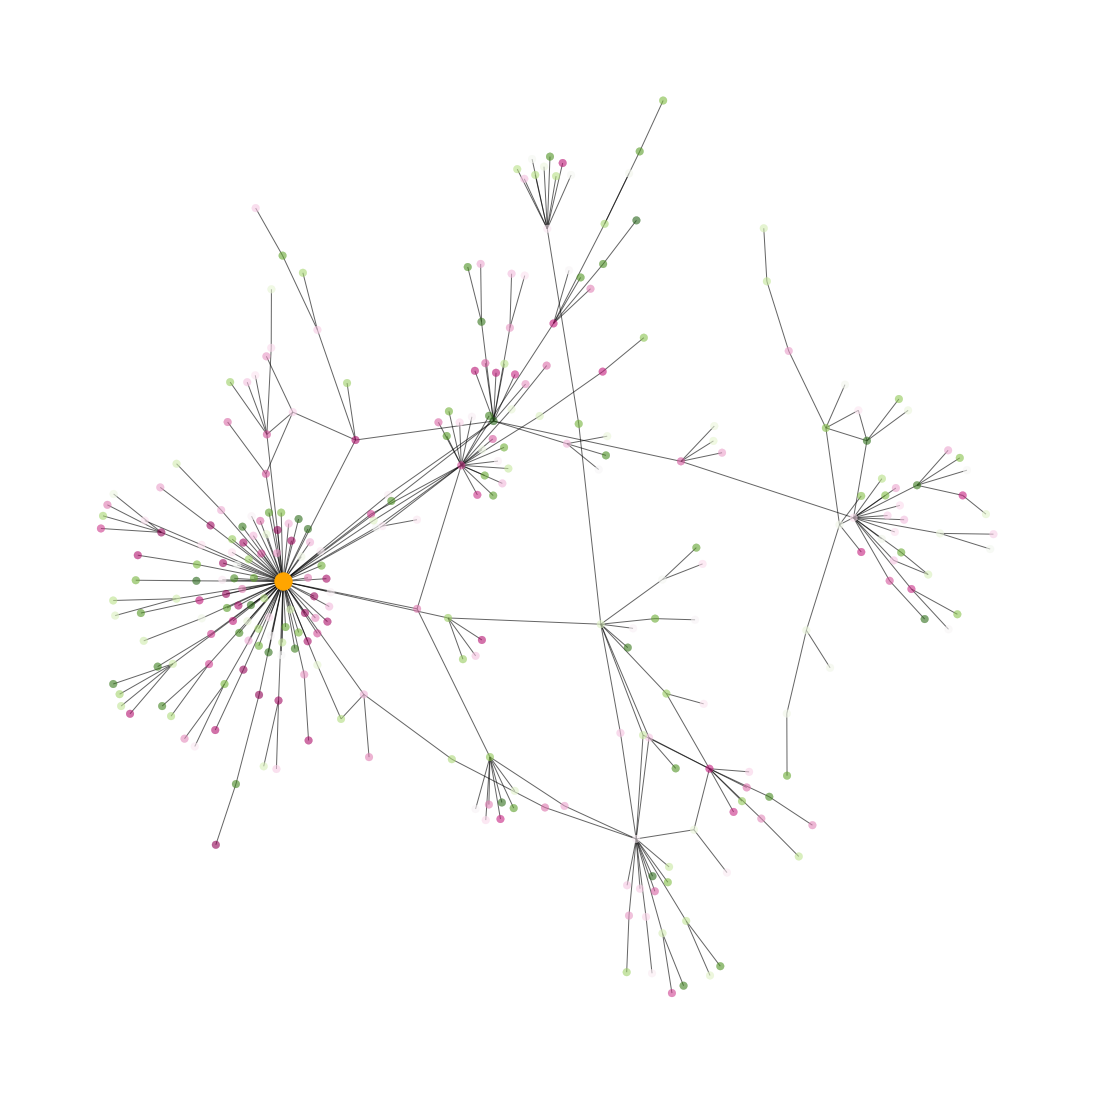

In [ ]:
plt.figure(figsize = (15,15))
nx.draw(largest_subgraph, pos=pos, node_color=range(largest_subgraph.number_of_nodes()), cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_node, node_size=300, node_color=colors_central_node)
plt.savefig('graphfinal.png')
plt.show()

## 6. Location Analysis

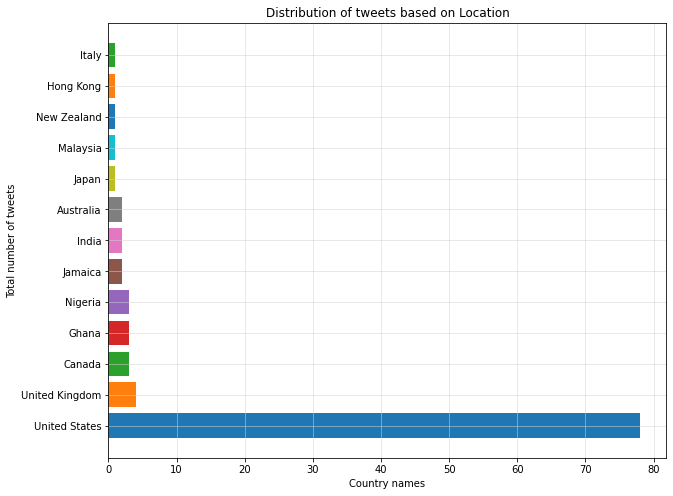

In [ ]:
# visualizing the distribution of the tweets based on tweets location
#defining data
df= pd.DataFrame({'country':list(total_data['place'].value_counts().index),'count':list(total_data['place'].value_counts()) })

#plotting data
plt.figure(figsize=(10,8))
plt.grid(True, linewidth=0.5, color='#D3D3D3', linestyle='-')
plt.barh(list(total_data['place'].value_counts().index), list(total_data['place'].value_counts()), color =sns.color_palette())
plt.title('Distribution of tweets based on Location')
plt.xlabel('Country names')
plt.ylabel('Total number of tweets')
plt.savefig('location.png')
plt.show()